## Introduction
Every once in a while, a python library is developed that has the potential of changing the landscape in the field of Deep Learning. PyTorch is one such library. In the past few months, I have been dabbling a bit in PyTorch. I have been blown away by how easy it is to grasp. Among the various deep learning libraries I have used till date – PyTorch has been the most flexible and effortless of them all.

Now we're going to build a deep neural network that can solve a (formerly) difficult problem, identifying text in an image. Here we'll use the MNIST dataset which consists of greyscale handwritten digits. Each image is 28x28 pixels, you can see a sample below

![MNIST](https://miro.medium.com/max/479/1*yBdJCRwIJGoM7pwU-LNW6Q.png)

Our goal is to build a neural network that can take one of these images and predict the digit in the image. Let's get straight into it


> Note: Don't worry if you're a beginner in Deep Learning, this tutorial assumes very little prerequisites.



## Imports
We need to import some libraries to kick things off first up.

**These are the most basic ones we need for any Machine Learning project:**

* **Numpy** for numerical computing. 

* **pandas** for structured data manipulation 

* **matplotlib** to plot some good looking graphs.

* **Scikit-learn** is imported for its useful `train_test_split` function here. (We may need many of its functions on a different project, sklearn is one of the most useful tools for Machine Learning you can find)


**Deep Learning Frameworks**

**PyTorch** - our secret sauce to implement Deep Neural Networks.



In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for plotting beautiful graphs

# train test split from sklearn
from sklearn.model_selection import train_test_split

# Import Torch 
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.autograd import Variable
from torch import nn, optim
import torch.nn.functional as F

# What's in the current directory?
import os
print(os.listdir("../data/"))

['train.csv', 'test.csv', 'sample_submission.csv']


## Import the Data

Let's start by importing and seeing what data we have at hand. As we have seen before pandas helps us analyze and manipulate structured data. 

**Our Data**:

digit-recognizer <br />
&nbsp; &nbsp; &nbsp; &nbsp;|--- sample_submission.csv <br />
&nbsp; &nbsp; &nbsp; &nbsp;|--- test.csv <br />
&nbsp; &nbsp; &nbsp; &nbsp;|--- train.csv <br/>
    
There is our three CSV files to start with, CSVs are just a way of representing tabular data in a form where commas are used as seperators which is simple to implement, easier to handle and represent. 

Pandas has its `read_csv` method that makes reading these CSV files in a format understandable by Python called `dataframe`.

Now lets see this in action...

In [2]:
train = pd.read_csv("../data/train.csv", dtype=np.float32)
final_test = pd.read_csv("../data/test.csv", dtype=np.float32)
sample_sub = pd.read_csv("../data/sample_submission.csv")
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Hmm, that looks like we have the pixel values not the images. (Probably you noticed that earlier, looking at the folder structure)

And that looks insanely long as well. Lets get to know more but a little smartly this time because we have `pandas` here to help us.

We can use pandas' `info` method to see more details about the data like how much data there is and the number of columns, which is the one we need to find as we need to know exactly how many pixels values we have. 

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: float32(785)
memory usage: 125.8 MB


* So each row contails 1 label and 784 of its pixel values which translates to one image.
* And there are 42,000 rows exactly. (starting from 0)
<br>
<br>

**label**: It is the actual ground truth value that the image represents, in this case it is between 0 - 9 as we are dealing with images with handwritten digits.

So the next question would naturally be how much data for each label we actually have, this is important because if the numbers are imbalanced or completely skewed we might have to use a completely different approach. 

We can do this by using the `value_counts` method of a pandas series. A series is just a single long sequence like one column alone in a dataframe so many series objects make up one dataframe object.

In [3]:
train['label'].value_counts()

1.0    4684
7.0    4401
3.0    4351
9.0    4188
2.0    4177
6.0    4137
0.0    4132
4.0    4072
8.0    4063
5.0    3795
Name: label, dtype: int64

So looks like our data is decently balanced.

## Preparing Dataset
> Throughout the notebook, I'll first provide an overview of what we are going to do and break everything down later to explain each line.

1. What we are doing here is taking the raw dataset and splitting into targets and features. Dividing by 255 makes each pixel value to scale between 0 and 1 instead of 0 and 255, which helps in training our model. This step in Machine Learning is generally known as Normalization. Then we split into train and test sets using sklearn's `train_test_split` function.

2. Converting the numpy arrays into PyTorch Tensors using `from_numpy` function. Don’t let the word “tensor” scare you. It is nothing more than a simple mathematical concept. Tensors are mathematical objects that generalize scalars, vectors and matrices to higher dimensions.

3. Batch size is set. The batch size is usually set between 64 and 256. The batch size does have an effect on the final test accuracy. One way to think about it is that smaller batches means that the number of parameter updates per epoch is greater. 

4. To pass our data into our PyTorch models we need to convert it to a PyTorch Dataset. A Tensor Dataset in this case. 

5. We have the training data loaded into trainloader and we can make an iterator with iter(trainloader) that can help us grab data. Later, we'll use this to loop through the dataset for training. Each time we can pull out data of the size of the batch that is defined.

In [4]:
# Seperate the features and labels
targets_np = train.label.values
features_np = train.loc[:, train.columns != 'label'].values/255

Whoa! So what was all that code? Yeah you know what it does from the overview you read earlier but how did I write this code? I'll explain...

`train.labels` gives us all the labels with indices, we don't need indices so the use `.values` attribute to get the values alone and save that in `targets_np` which means targets in numpy array format.

`train.loc` lets us access the rows and columns in this fashion `[rows, columns]`, it helps us get what we need from the dataframe. (Note that it is not a function and you are not calling it, it is more like indexing) 

`train.loc[:, train.columns != 'label']` means we want all the rows for which we use `:` and all the columns except `label` so we do  `train.columns != 'label'`. 

Again we are interested only in values so we use `.values` attribute. 

In the end, we divide it by 255 to normalize the pixel values. As we have pixel values all only in the range 0 - 255 diving by 255 brings it down to 0 - 1 scale. 


**So, Why normalization?**

* When the parameter space in big, like in our case 0 - 255, this can have a significant effect when training neural networks. A model with large weight values will be unstable because of the way neural networks work and it can quickly lead to problems like exploding gradients in a regression task. 

* So one way to change the scale of the data without changing the distribution of the data is called normalization. Since we know the pixel values always range in between 0 and 255 diving by 255 will naturally bring it down to 0 - 1 scale. 

* But this may not be the case for all problems you may face, you should then use Min-Max Scaling instead. Which can be done like this,
    `X_normalized = (X - min)/(max - min)` for while you can also use Scikit-learn's built in MinMaxScaler which does exactly the same thing for you.

In [5]:
# Split into training and test set
features_train, features_test, target_train, target_test = train_test_split(features_np, targets_np, 
                                                                            test_size=0.2, random_state=42)

Now as we have the pixel values and targets well separated we can use the `train_test_split` function from Scikit-learn to divide our data into two distinct train and test sets.

We pass the features and targets we created above and specify the `test_size`, in this case 0.2 means use 20% for test set and the rest (80%) for the train set. 

`random_state` as the name suggests, is used for initializing the internal random number generator, which will decide the splitting of data into train and test indices. In simpler terms when we use the same `random_state` the randomizer will output the same set of values all the time. This is useful because we may need to reproduce the same results.

And also we may never want to inadvertantly train on the test set on another session, in Machine Learning the test set has to be constant all the time.

In [6]:
# create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(target_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(target_test).type(torch.LongTensor) # data type is long

Okay now as I have mentioned earlier we are converting arrays (what we normally have in numpy) into tensors which our Neural Networks use. For that we use PyTorch's `from_numpy` function for both train and test sets.

In [7]:
# Set batch size
batch_size = 256

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = True)

We have discussed the batch size earlier, 256 here means we'll be updating the model parameters (which governs what the model learns) for every 256 images by computing the gradient usually using algorithms like Gradient Descent.

Then we convert our tensors into a Tensor Dataset, which is essential for Deep Learning in PyTorch.

The data loader gives us the data back in batches as we loop over them, here we have specified our batch size and set shuffle to `True` because the order of images here is insignificant. 

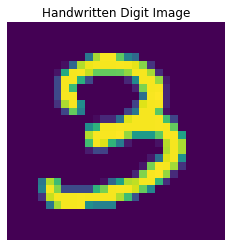

In [8]:
# visualize one of the images in data set
def visualize_image(data, index, pred=False, val=0):
    '''This funtion can be used to visualize the images'''
    plt.imshow(data[index].reshape(28,28))
    plt.axis("off")
    plt.title("Handwritten Digit Image")
    plt.show()
    
visualize_image(features_np, 14)

Since we have the pixels we can convert them back to images by reshaping them into a 28x28 square (as we have 784 values)

Matplotlib's `imshow` function lets us visualize images like that directly by inferring from our numpy array itself.

In [9]:
featuresTrain.shape

torch.Size([33600, 784])

Looking at the shape of train data, we can see that we have 33,600 images. 

Now finally it is time to move into real Deep Learning stuff...

## Define Network Architecture

Covering how Neural Networks work is much beyond the scope of this notebook. For that by far the best explanations I have found have been in Andrew Ng's tutorials which you may want to have a look if you don't yet understand NNs.

Now lets start with some simple terms,

`Input Layer` - The initial layers that accepts our data as input. The input is called X

`Hidden Layer` - All the layers in between the input layer and the final layer which does all the (black-box) learning. 

`Output Layer` - The final layer of our Neural Network that gives out the predictions. The outputs are called Y

The architecture of the Neural Network is not purely arbitrary, you have to choose the one that works best for you, as a result of a lot of experimentation.

PyTorch provides a module `nn` that makes building networks much simpler. 

Here I'll show you how to build the same with 784 inputs (as we have 784 pixel values), hidden units with 512, 256, 128, 64 neurons in each hidden layer, 10 output units as we have 10 classes to classify, and a softmax output for multi-class classification. 

It is quite similar to the one example image below.

![Example](https://assets.digitalocean.com/articles/handwriting_tensorflow_python3/cnwitLM.png)

In [11]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        # 5 Hidden Layer Network
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 probbability
        self.dropout = nn.Dropout(p=0.2)
        # Add softmax on output layer
        self.log_softmax = F.log_softmax
        
    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        
        x = self.log_softmax(self.fc5(x), dim=1)
        
        return x

Well, that was a bit too much, isn't it?

Let's go through this bit by bit.

`class Network(nn.Module):`

Here we're inheriting from `nn.Module`. Combined with `super().__init__()` this creates a class that tracks the architecture and provides a lot of useful methods and attributes. It is mandatory to inherit from nn.Module when you're creating a class for your network. The name of the class itself can be anything.

`self.hidden = nn.Linear(784, 512)`

This line creates a module for a linear transformation, $\mathbf{W}x + b$, with 784 inputs and 512 outputs and assigns it to `self.hidden`. The module automatically creates the weight and bias tensors which we'll use in the `forward` method. You can access the weight and bias tensors once the network (net) is created with `net.hidden.weight` and `net.hidden.bias`.

`self.output = nn.Linear(64, 10)`

Similarly, this creates another linear transformation with 64 inputs and 10 outputs.

`
self.log_softmax = F.log_softmax`

Here I defined operations for the log softmax activation that is used at the output layer. Setting `dim=1` in `F.log_softmax(dim=1)` calculates softmax across the columns. 

**So why Softmax? And what is it doing?**

* The outputs from neural networks will be in form of probabilities if you don't know that already.
* By looking at the labels and the task description it is clear that we don't have to output probabilities, the number found in the image instead. (The label)
* This is why our output layer contains 10 outputs in the first place. 
* The ouputs of these 10 layers are in probabilities, we have to somehow convert them to a prediction which contains a digit.
* This is where softmax comes in, what it does is pretty simple, **it takes the probabilities, finds the maximum probability for a certain input, and makes it 1 and making the rest of the outputs 0** that way we can get our predictions working. 

`self.dropout = nn.Dropout(p=0.2)`

The most common method to reduce overfitting (outside of early-stopping) is dropout, where we randomly drop input units. This forces the network to share information between weights, increasing its ability to generalize to new data. Adding dropout in PyTorch is straightforward using the `nn.Dropout` module. In short, this means for every neuron there is a 20% chance that it is being ignored  all the time.


`def forward(self, x):`

PyTorch networks created with `nn.Module` must have a forward method defined. It takes in a tensor x and passes it through the operations you defined in the __init__ method.

`x = self.dropout(F.relu(self.fc1(x)))
x = self.dropout(F.relu(self.fc2(x)))
x = self.dropout(F.relu(self.fc3(x)))
x = self.dropout(F.relu(self.fc4(x)))`

Here the input tensor `x` is passed through each operation and reassigned to `x`. We can see that the input tensor goes through the hidden layer, then a ReLU function, then the output layer, and finally the softmax function. 


**Activation Functions and why ReLU?**
* The outputs of NNs are in linear form $\mathbf{W}x + b$ with $\mathbf{W}$ being the Weight matrix and $b$ being the bias matrix that is being learned (in order to give the right final output) across all the neurons, these are called parameters. There are usually millions of these parameters that are being learned in a deep neural network.

* So just taking these output values of each neuron is fine, the easiest way to build and train one, this activation is called Linear Activations where no transformation is applied. That means the linearity of neurons in unchanged. 

* In a neural network we do complex multiplication and summing operations of these values at each node, turns out that when we use a Linear Activation we cannot capture more complex information as we have no mechanism in place to control how much each neuron gets activated to learn the intricate features represented in the data.

* Note that this can still be used if we are expecting the output to be continuous values. (Regression) But for us (Classification) as it turns out this won't be all that effective to use, so we move to non-linear activation functions.

* Non-linear activations let the neurons learn more complex features from the data by letting these neurons have sensitivity to specific features. We won't be going around setting which neurons detect which features by the way, that's why we train the algorithms with the data, to come up with an architecture where we can capture these intricate features just by running a few rounds through the data. 

* Two of the popular activation functions are `sigmoid` and `tanh` which are common in Machine Learning. In short, the caveats of using them on Neural Networks is that they saturate easily, for example if we give it a large value, sigmoid will squish it between 0 and 1 and `tanh` between -1 and 1. Which means after a certain rounds of training we might not be able to show any more differentiation to adapt the weights to keep learning more complex features. Which means this is simply not good enough for Deep Neural Networks as we would have to do this a lot more times.

* And also this may lead to Exploding Gradients problem or Vanishing Gradients problem which can completely ruin the ability of the Neural Network to learn.

* So what `ReLU` does is very simple, it only gets activated for positive values. So why is it helpful? It is being linear half the times and non-linear half the times, making adaptation much easier while training. Also effectively ruling out some of the problems of `sigmoid` and `tanh`. 

* In short, `ReLU` provides the necessary sensitivity as well as preventing easy saturation.


## Training and Validation 

Before moving on to training there is some key steps and components that make training work.

1. Data (Of course we have)
2. Model (We have implemented one above)
3. Loss Function
4. Optimizer 
5. Evaluation Metric

You know the answer to the first two by now. We'll discuss the rest here,

**Loss Function:** <br>
* A loss function is the one that helps us measure how good our model's predictions are against the ground truth values. 

* We optimize our model to eventually bring this loss down. One example in a regression task would be to take the absolute error between actual and predicted values. 

* But for classification this is not that simple. We have to come up with a different loss function like Negative Log Likely-hood loss or Cross Entropy loss or Binary Cross Entropy Loss. 

* You can read more about these loss functions [here](https://machinelearningmastery.com/loss-and-loss-functions-for-training-deep-learning-neural-networks/)

**Optimizer:**
* So now it is clear that we need to tune the parameters using some mechanism that takes these loss functions into account and ultimately tries to *minimize* it. This task is done by the optimizer. 
* When talking about Optimizers one of the most famous ones is the `Gradient Descent Optimizer`. It follows these 3 steps,

    1. Computes the Loss.
    2. Adjusts the parameters (Weights and biases) according to their gradients which means taking a step in the correct direction.
    3. Repeat until the loss is as low as possible.
    

* There are several optimizers but most of them are just variants of the `Gradient Descent` Optimizer.
* One of the most succesful Optimizer when it comes to Neural Networks is the `Adam` optimizer which means `Adaptive Moment Estimation`. In short, it uses a concept called momentum, it takes fractions of the previously computed gradients also into account while computing the current gradient. 


**Evaluation Metric:**

As the name suggests it lets us evaluate the performance of the model in a meaningful way rather than just the losses. One of the most common example for an evaluation metric is `accuracy` which we are going to use here.

Now we should create our own network and train it. First we'll want to define the criterion, the loss (something like `nn.CrossEntropyLoss` or `nn.NLLLoss`) and the optimizer (typically `optim.SGD` or `optim.Adam`).
* Make a forward pass through the network
* Use the network output to calculate the loss
* Perform a backward pass through the network with `loss.backward()` to calculate the gradients
* Take a step with the optimizer to update the weights

An **epoch** means we have gone over the entire dataset once, taking the actions mentioned above.

In [12]:
# Instantiate our model
model = Classifier()
# Define our loss function
criterion = nn.NLLLoss()
# Define the optimier
optimizer = optim.Adam(model.parameters(), lr=5e-04)

epochs = 25
steps = 0
print_every = 50
train_losses, test_losses = [], []

for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        steps += 1
        # Prevent accumulation of gradients
        optimizer.zero_grad()
        # Make predictions
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        #backprop
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0

            # Turn off gradients for validation
            with torch.no_grad():
                model.eval()
                for images, labels in test_loader:
                    log_ps = model(images)
                    test_loss += criterion(log_ps, labels)

                    ps = torch.exp(log_ps)
                    # Get our top predictions
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor))

            model.train()

            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(test_loader))

            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(train_losses[-1]),
                  "Test Loss: {:.3f}.. ".format(test_losses[-1]),
                  "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

Epoch: 1/25..  Training Loss: 0.639..  Test Loss: 0.744..  Test Accuracy: 0.746
Epoch: 1/25..  Training Loss: 0.895..  Test Loss: 0.444..  Test Accuracy: 0.863
Epoch: 2/25..  Training Loss: 0.061..  Test Loss: 0.342..  Test Accuracy: 0.902
Epoch: 2/25..  Training Loss: 0.200..  Test Loss: 0.274..  Test Accuracy: 0.919
Epoch: 2/25..  Training Loss: 0.318..  Test Loss: 0.232..  Test Accuracy: 0.933
Epoch: 3/25..  Training Loss: 0.070..  Test Loss: 0.207..  Test Accuracy: 0.938
Epoch: 3/25..  Training Loss: 0.157..  Test Loss: 0.190..  Test Accuracy: 0.944
Epoch: 4/25..  Training Loss: 0.006..  Test Loss: 0.176..  Test Accuracy: 0.950
Epoch: 4/25..  Training Loss: 0.076..  Test Loss: 0.159..  Test Accuracy: 0.953
Epoch: 4/25..  Training Loss: 0.142..  Test Loss: 0.147..  Test Accuracy: 0.956
Epoch: 5/25..  Training Loss: 0.023..  Test Loss: 0.142..  Test Accuracy: 0.958
Epoch: 5/25..  Training Loss: 0.079..  Test Loss: 0.131..  Test Accuracy: 0.960
Epoch: 5/25..  Training Loss: 0.132..  T

Oh what just happended there? I'll explain not to worry.

#### Training: 
* I'm looping over the train loader, pulling out the images and labels.
* Note that I have a line of code `optimizer.zero_grad()`. When you do multiple backwards passes with the same parameters, the gradients are accumulated. This means that you need to zero the gradients on each training pass or you'll retain gradients from previous training batches.
* I have named the next variable `log_ps` because our model gives us back logs of class probabilities, you can take exponent to convert it to normal probabilities which I've done down below for validation. 
* We calculate the loss. Then backpropagate through the network. We then make one optimizer step. Which brings us closer and closer to the global optimum.

#### Validation
* We turn off the gradients for validation as it is not needed and saves a lot of memory and computation. Note that we should turn it back on after each step of validation.
* We loop over the test_loader and essentially repeat some steps we have done above. Since it's validation we don't need to backpropagate. 
* The next step - With the probabilities, we can get the most likely class using the ps.topk method. This returns the $k$ highest values. Since we just want the most likely class, we can use `ps.topk(1)`. This returns a tuple of the top-$k$ values and the top-$k$ indices. If the highest value is the fifth element, we'll get back 4 as the index.
* Then we check if the predicted value is equal to the actual value. 
* We then calculate the percentage of correct predictions, which indeed is using the mean of our top predictions. But you cannot just use `torch.mean` because `topk` returns a byte tensor but we need a float tensor to perform torch.mean we do that in the next step.

The same process is repeated over and over again. The results are printed on each step. With this simple model we're able to get about 98% accuracy on validation which is awesome, isn't it?

Hope that made sense. 

## Visualizing Model Performance

One way to better understand if the training was effective other than the evaluation metric is to look at the training loss and validation loss history while doing the training. That way we can decide,
* After how many epochs we could safely stop training. (Losses plateau out)
* Determine underfitting and overfitting.
* Adjusting learning rate and other hyper parameters.

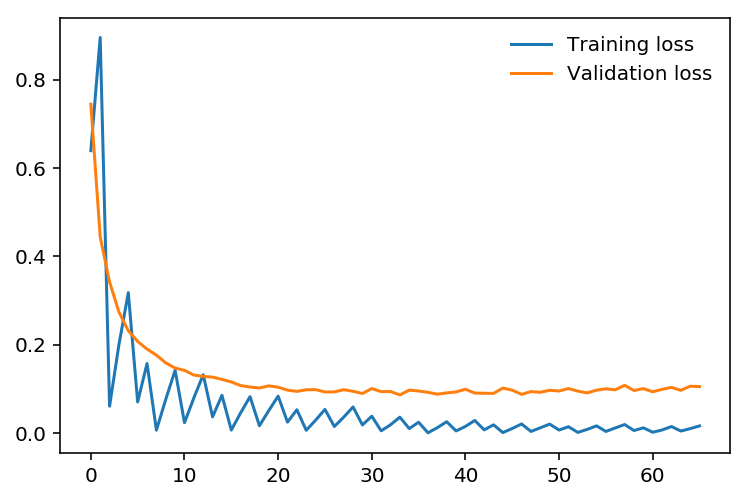

In [13]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

This graph looks decent to me. We're doing fairly well for our first model in PyTorch.

## Inference
Inference is a crucial part of any machine learning project. This could give you a fair idea of how well your model performs in unseen data. 

In Inference we only make a forward pass through the network and make predictions and do nothing else. Just like how it would be used after moving it to production.


You can see what out model is predicting here on the test data. You can try playing around with this function for different images. 

As expected our model seems to do well, infact really well.

In [14]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

Every single line must be intuitive there, I'll explain if it is not

So what `squeeze()` does is it takes the single dimensional entries out by squeezing the array.

So we create subplots, we need the image and predicted label confidence chart side by side. We don't need axis to be displayed. The bar has to horizontal to look good so `barh` and that is it.

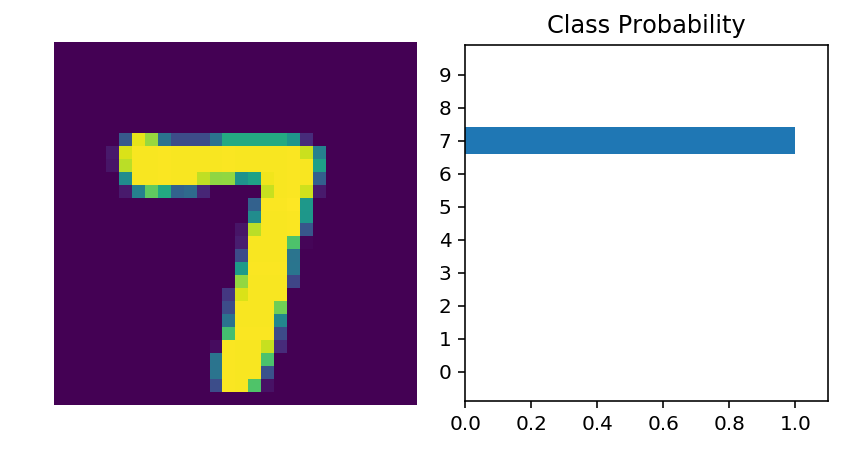

In [15]:
%matplotlib inline
def make_prediction(data):
    images, labels = next(iter(data))

    img = images[10].view(1, 784)
    # Turn off gradients to speed up this part
    with torch.no_grad():
        logps = model(img)

    # Output of the network are log-probabilities, need to take exponential for probabilities
    ps = torch.exp(logps)
    view_classify(img.view(1, 28, 28), ps)
    
make_prediction(test_loader)

* The `make_prediction` function takes each batch, by iterating over it, turns gradients off as we are not computing anything here, gets the outputs of the model. Since these outputs are in `log` we have to take exponential of the output to get back the true outputs. 

* Then it calls the `view_classify` to plot the image with the predicted value. It does this using simple matplotlib features.

## Preparing Test Data for Prediction

Please note this is really important we have to apply the same transformations to test data as we did for train (except data augmentation if any). 

So all these transformations may look a lot familiar to you we normalize the pixel values and convert it to tensor.

In [16]:
final_test_np = final_test.values/255
test_tn = torch.from_numpy(final_test_np)

In [17]:
# Creating fake labels for convenience of passing into DataLoader
## CAUTION: There are other ways of doing this, I just did it this way
fake_labels = np.zeros(final_test_np.shape)
fake_labels = torch.from_numpy(fake_labels)

In [18]:
test_tn_data = torch.utils.data.TensorDataset(test_tn, fake_labels)

test_loader = torch.utils.data.DataLoader(test_tn_data, batch_size = batch_size, shuffle = False)

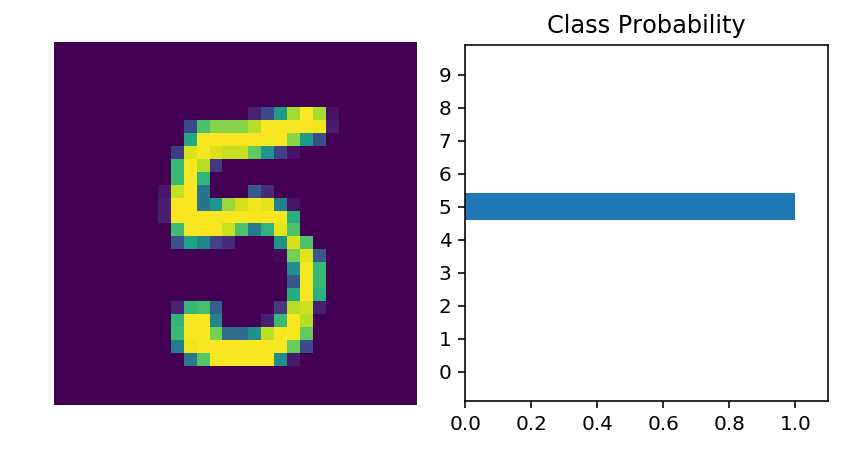

In [19]:
# Seeing what our model does on test data
make_prediction(test_loader)

## Making Predictions on Test data

Now we actually pass the data inside the model to get back predictions and save these predictions in an output file.

This output file is now a dataframe which can be saved as a CSV file.

In [20]:
# Making it submission ready
predictions = [['ImageId', 'Label']]

# Turn off gradients for validation
with torch.no_grad():
    model.eval()
    image_id = 1
    for images, _ in test_loader:
        log_ps = model(images)
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        
        for prediction in top_class:
            predictions.append([image_id, prediction.item()])
            image_id += 1

In [21]:
predictions_df = pd.DataFrame(predictions)
predictions_df.columns = predictions_df.iloc[0]
predictions_df = predictions_df.drop(0, axis=0)

In [22]:
predictions_df.head()

,ImageId,Label
1,1,2
2,2,0
3,3,9
4,4,9
5,5,3


Now we can save this dataframe as a CSV file using pandas's `to_csv` function. 

In [23]:
predictions_df.to_csv("../results/predictions.csv", index=False)

## Conclusion

PyTorch may seem a little confusing at first but once you get the rhythm, it all becomes much easier.

If you are worried about having to rewrite a lot of the same code for different projects you can use PyTorch `Catalyst`, `Ignite`, or `Lightning` they give you a higher level API (giving you the boiler plate code) which can save a ton of your time.

Thanks for reading all the way. I really hope this tutorial was helpful and you atleast learned a few things about Deep Learning and PyTorch.

**Authored by:**
[Abhinand](https://www.linkedin.com/in/abhinand-05/)